In [45]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [46]:
PATH_FILES = 'inputs/'

### Passo 0
Leitura das imagens

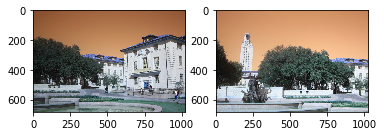

In [47]:
img_a = cv2.imread(PATH_FILES + 'foto1A.jpg')
img_b = cv2.imread(PATH_FILES + 'foto1B.jpg')

plt.subplot(121), plt.imshow(img_a)
plt.subplot(122), plt.imshow(img_b)
plt.show()

### Passo 1
Converter as imagens coloridas de entrada em imagens de níveis de cinza.

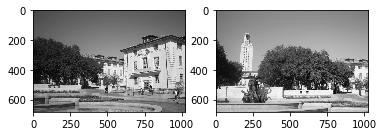

In [48]:
img_gray_a = cv2.cvtColor(img_a, cv2.COLOR_BGR2GRAY)
img_gray_b = cv2.cvtColor(img_b, cv2.COLOR_BGR2GRAY)

plt.subplot(121), plt.imshow(img_gray_a, cmap='gray')
plt.subplot(122), plt.imshow(img_gray_b, cmap='gray')
plt.show()

### Passo 2
Encontrar pontos de interesse e descritores invariantes locais para o par de imagens.

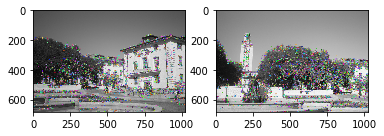

True

In [49]:
# aplicando a tecnica do SIFT
sift = cv2.xfeatures2d.SIFT_create()
# encontra os pontos chaves e os descritores
kp_img_a, des_a = sift.detectAndCompute(img_gray_a,None)
kp_img_b, des_b = sift.detectAndCompute(img_gray_b,None)
# cria copias da imagem original para marcar os descritores
img_sift_a = img_gray_a.copy()
img_sift_b = img_gray_b.copy()
img_sift_a = cv2.drawKeypoints(img_gray_a, kp_img_a, img_sift_a)
img_sift_b = cv2.drawKeypoints(img_gray_b,kp_img_b, img_sift_b)
# plota as imagens com os descritores marcados
plt.subplot(121), plt.imshow(img_sift_a, cmap='gray')
plt.subplot(122), plt.imshow(img_sift_b, cmap='gray')
plt.show()
# salva as imagens
cv2.imwrite('outputs/foto1A-sift.jpeg', img_sift_a)
cv2.imwrite('outputs/foto1B-sift.jpeg', img_sift_b)

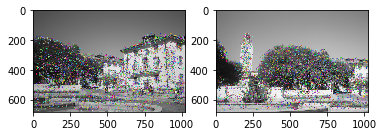

True

In [50]:
# aplicando a tecnica do SURF
surf = cv2.xfeatures2d.SURF_create()
# encontra os pontos chaves e os descritores
kp_surf_img_a, des_surf_a = surf.detectAndCompute(img_gray_a,None)
kp_surf_img_b, des_surf_b = surf.detectAndCompute(img_gray_b,None)
# cria copias da imagem original para marcar os descritores
img_surf_a = img_gray_a.copy()
img_surf_b = img_gray_b.copy()
img_surf_a = cv2.drawKeypoints(img_gray_a, kp_surf_img_a, img_surf_a)
img_surf_b = cv2.drawKeypoints(img_gray_b, kp_surf_img_b, img_surf_b)
# plota as imagens com os descritores marcados
plt.subplot(121), plt.imshow(img_surf_a, cmap='gray')
plt.subplot(122), plt.imshow(img_surf_b, cmap='gray')
plt.show()
# salva as imagens
cv2.imwrite('outputs/foto1A-surf.jpeg', img_surf_a)
cv2.imwrite('outputs/foto1B-surf.jpeg', img_surf_b)

### Passo 3


Computar distâncias (similaridades) entre cada descritor das duas imagens.

In [64]:
# usa o BFMatcher (com parametros default) para encontrar as similaridades
bf = cv2.BFMatcher()
sift_matches = bf.knnMatch(des_a,des_b, k=2)
surf_matches = bf.knnMatch(des_surf_a,des_surf_b, k=2)